# Neural Networks
In this notebook we will build a simple fully connected neural network with 1 hidden layer to classify points in $R^2$. We have already seen that each layer of a feedforward neural network computes an affine map followed by a nonlinearity applied elementwise:
$$
h^{l+1} = a(W^l h^l + b^l)
$$

First we create the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.utils import shuffle

In [2]:
N=400
angles = np.random.uniform(0,2*np.pi,size=N//2)
r1 = np.random.uniform(0,1.5,size=N//2)
r2 = np.random.uniform(2,3.5,size=N//2)
X_1 = np.stack([
    r1 * np.cos(angles),
    r1 * np.sin(angles)
],axis=-1)
X_2 = np.stack([
    r2 * np.cos(angles),
    r2 * np.sin(angles)
],axis=-1)

In [3]:
X = np.concatenate([X_1,X_2],axis=0)
Y = np.concatenate([
    np.zeros(shape=(X_1.shape[0]),dtype=np.float32),np.ones(shape=(X_2.shape[0]),dtype=np.float32)
])
X,Y = shuffle(X,Y,random_state=8)
Y = Y[:,None]

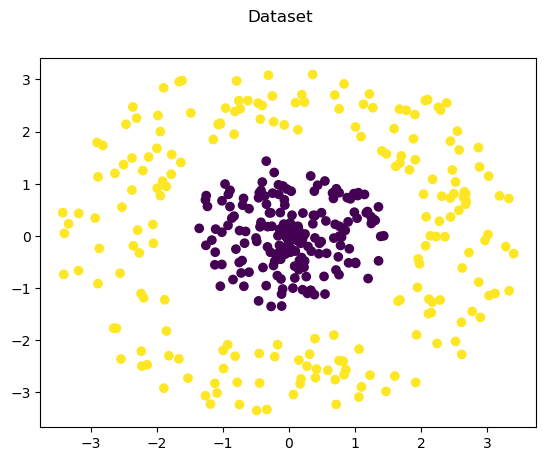

In [4]:
fig,ax = plt.subplots()
ax.scatter(x=X[:,0],y=X[:,1],c=Y[:,0])
fig.suptitle("Dataset")
plt.show()

Then we create the Neural Network. In PyTorch a Neural Network is a subclass of `nn.Module`. In the constructor we initialize the layers of our model, while in the `__call__` method we need to specify the flow from the input to the output tensors, that will be used to instantiate the computational graph.

In [5]:
from typing import Any

class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.d1 = nn.Linear(in_features=2,out_features=5,bias=True)
        self.d2 = nn.Linear(in_features=5,out_features=1,bias=True)

    def __call__(self, x) -> Any:
        o = self.d1(x)
        o = torch.relu(o)
        o = self.d2(o)
        o = torch.sigmoid(o)
        return o

Then we define the loss function, this is a binary classification task so we can use the `binary_cross_entropy` loss (as we have studied in the [notebook](./04classification.ipynb) about binary classification).

In [6]:
loss = torch.nn.functional.binary_cross_entropy

Then we need to instantiate the model and an optimizer. In this example we will use Stocastic Gradient Descent, even tough a lot of more sophisticated optimizers are available in the module `torch.optim`. The optimizer performs the update of the parameters 
of the network with respect to the gradient, for example the SGD optimizer uses the update rule that we are already familiar with:
$$
\mathbf{w_{new}} = w_{old} - \eta \frac{\partial L}{\partial \mathbf{w}}
$$
Where $\eta$ is the learning rate. The optimizer takes as argument the parameters that must be optimized, that can be retrieved using the method `net.parameters()`.

In [7]:
LR = 10**-3

net = Network()
opt = torch.optim.SGD(params=net.parameters(),lr=LR)

In [8]:
from utils import get_n_params
print(f"Number of trainable parameters: {get_n_params(net)}")

Number of trainable parameters: 21


Then we need to implement the training loop. We will train the model for 10 epochs (we will iterate 10 times over the whole dataset). At each iteration:
- we select a batch from the trainingset (in this case 32 samples), note that the samples must be taken at random. This because we are approximating the gradient using only a subset of the trainingset, hence the batch should be a sample from the training data distribution.
- we compute the predictions of the network
- we compute the loss function
- we compute the gradient of the loss function with respect to the parameters. This is obtained calling `l.backward()`, this method performs a backward pass on the computational graph and at each node stores the gradient of the loss with respect to that node.
- we update the parameters with `opt.step()`. This method uses the gradient stored in each node of the computational graph to compute the new value of the node.
- for each batch we print the actual value of the loss function.

In [9]:
EPOCHS = 10
BS = 32

losses = []
ep_losses = []

N = X.shape[0]
for e in range(EPOCHS):
    for step in range(0,N,N//BS):
        X_B = torch.tensor(X[step:step+BS,:],dtype=torch.float32)
        Y_B = torch.tensor(Y[step:step+BS],dtype=torch.float32)
        O = net(X_B)
        l = loss(O,Y_B)
        l.backward()
        opt.step()
        print(f"step:{step//BS}/{N//BS} \tep:{e}/{EPOCHS} \t loss:{l.item()}")
        losses.append(l.item())
    ep_losses.append(l.item())


step:0/12 	ep:0/10 	 loss:0.6998563408851624
step:0/12 	ep:0/10 	 loss:0.6966545581817627
step:0/12 	ep:0/10 	 loss:0.7313718795776367
step:1/12 	ep:0/10 	 loss:0.8173807859420776
step:1/12 	ep:0/10 	 loss:0.7279143333435059
step:1/12 	ep:0/10 	 loss:0.6799303889274597
step:2/12 	ep:0/10 	 loss:0.5846912860870361
step:2/12 	ep:0/10 	 loss:0.5521045923233032
step:3/12 	ep:0/10 	 loss:0.5339697003364563
step:3/12 	ep:0/10 	 loss:0.5370100140571594
step:3/12 	ep:0/10 	 loss:0.5637874007225037
step:4/12 	ep:0/10 	 loss:0.6528998017311096
step:4/12 	ep:0/10 	 loss:0.6485422253608704
step:4/12 	ep:0/10 	 loss:0.6884493231773376
step:5/12 	ep:0/10 	 loss:0.6609920859336853
step:5/12 	ep:0/10 	 loss:0.7082318663597107
step:6/12 	ep:0/10 	 loss:0.6795517206192017
step:6/12 	ep:0/10 	 loss:0.6953568458557129
step:6/12 	ep:0/10 	 loss:0.6035214066505432
step:7/12 	ep:0/10 	 loss:0.5151875615119934
step:7/12 	ep:0/10 	 loss:0.48213768005371094
step:7/12 	ep:0/10 	 loss:0.5970577597618103
step:8/12

After the training, we plot the average loss for each epoch.

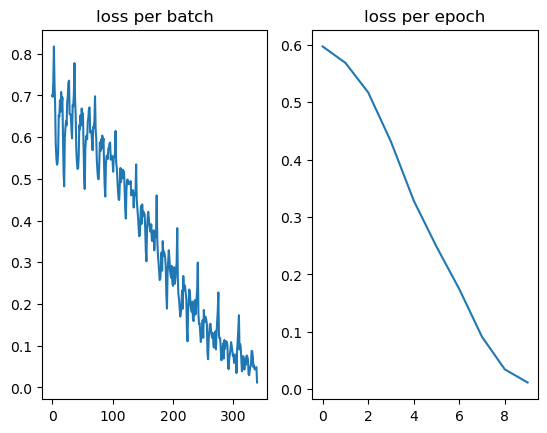

In [10]:
fig,ax = plt.subplots(1,2)
ax[0].plot(losses)
ax[0].set_title("loss per batch")
ax[1].plot(ep_losses)
ax[1].set_title("loss per epoch")
plt.show()

Then we show the predictions of the model, remember that the output of the model is the probability distribution over the two classes (that in this case is a scalar in the range [0,1]).

In [11]:
Y_Pred = net(torch.tensor(X,dtype=torch.float32)).detach().numpy()

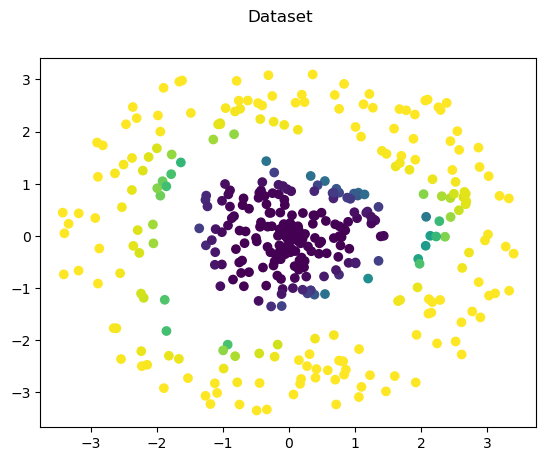

In [12]:
fig,ax = plt.subplots()
ax.scatter(x=X[:,0],y=X[:,1],c=Y_Pred[:,0])
fig.suptitle("Predicted Probabilities")
plt.show()

If we want a discrete label rather than a probability distribution we can threshold the predictions, for example if the predicted value is more then 50% we assign the point to class 1, otherwise to class 0.

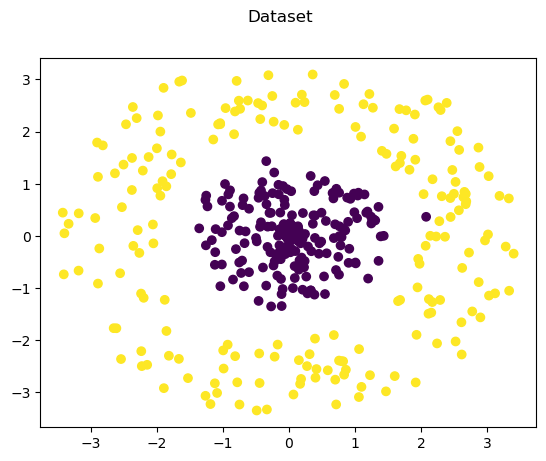

In [13]:
Y_Pred[Y_Pred>=0.5] = np.ones_like(Y_Pred[Y_Pred>=0.5])
Y_Pred[Y_Pred<0.5] = np.zeros_like(Y_Pred[Y_Pred<0.5])
fig,ax = plt.subplots()
ax.scatter(x=X[:,0],y=X[:,1],c=Y_Pred[:,0])
fig.suptitle("Predicted Labels")
plt.show()